<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">


# Credit Card Fraud Detection
# (Data formulation, and cleaning)

## Executive Summary

### Aims
The objective of this project is to build a predictor for credit card fraud.  It needs to be capable of identifying fraud based on credit card transactions, and typical information the credit-card company would hold about the cards used or their users (the card-company's customers).  Credit card fraud is thankfully a rare occurrance!  However, this sets the accuracy bar very high for a credit-card fraud predictor.  There will be a large imbalance between non-fraud cases (our "majority class") and the fraud cases we are trying to identify (our "minority class").  Such class imbalance presents challenges for machine learning algorithms and suitable approaches have to be taken.

### The data
The data used for this project is a data set found on Kaggle, here->https://www.kaggle.com/datasets/ealtman2019/credit-card-transactions.  It consists of over 24M card transactions relating to 2000 US-based card users and spanning a period of 20 years (1995-2020).  It is simulated data, but has been created (by IBM) for the purpose of building machine-learning algorithms to detect fraud.  It contains 3 files:-
- Transactions:  id of the customer and card, information about the vendor, the date, time and value of the transaction, etc.
- Users:  Credit-card company customer data, including demographic information, address, credit scoring, etc.
- Cards:  Credit-card details including type and brand of card, security features, etc.
The data can be "joined" together using each user's unique id and the credit card numbers.

The transactions contain almost 30,000 fraud cases (around 0.1%).

A subset (approximately one sixth) of the data was used for this project due to the limited hardware available.

### Success metrics
The main success metric is the accuracy of the fraud-predictor (a classification model) and therefore the metrics used to evaluate such models, such as precision and recall scores, AUC score, etc.  Also the success of the model can be put into simple business terms by looking at the number of fraud cases it correctly classifies verses those incorrectly classified.  Incorrectly classified results have clear business implications - either fraud cases which "slip the net" and are classified as non-fraud, or non-fraud cases which are incorrectly flagged as fraud.  The latter could result in additional manual checks which place a burden on the credit-card-provider and/or the customer.

### Findings

The exploratory data analysis showed that the data contained lots of features which should enable an effective model.  It also identified the potential to add (engineer) extra features which were subsequently used to improve our fraud predictor.

Various different classification models were used to find the best fraud predictor.  When this had been identified we shifted the threshold at which the model would predict a fraud case to illustrate the trade off between flagging less non-fraud cases as fraud verses more completely identifying fraud cases.

Through EDA and modelling we found certain transaction features correlated highly with fraud, such as:-
- Whether the transaction took place online (verses the card holder being physically present).
- Whether the transaction took place on home soil (in the US) or abroad.
- The value of the transaction (including in the context of the user's "usual" spend).
- The "Merchant Category Code" for the transaction (the kind of retailer).
- The location of the retailer.
- The time of day of the transaction.

A predictor was created which could correctly classify 98.5 % of all fraud cases.  It did this at the expense of incorrectly flagging about 3.5% of all transactions as fraud.  Or we can move the prediction threshold to the point where only 0.5% of transactions are incorrectly flagged as fraud, at the expense of allowing 15% of fraud cases to "slip the net" and be incorrectly classified as non-fraud cases.

### Risks and limitations

I only used about one-sixth of the available data due to computation constraints.  There is a risk that certain scenarios are not well represented in the data sub-set I used.

The project was limited in time and there was plenty of scope for further work with the potential to improve the model further.  Further work is outlined at the end of this notebook.

# Imports

In [1]:
from pprint import pprint
import numpy as np
import pandas as pd
import re
import time
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from datetime import datetime

In [3]:
# import my own EDA class
from jh_eda_classes import Eda

In [4]:
# set so that I can view all the columns in the data frame.
pd.set_option('display.max_columns', None)

## Loading and cleaning the transaction data

In [22]:
trans_df = pd.read_csv('~/GA/capstone2-data/credit_card_transactions-ibm_v2.csv')

In [23]:
trans_df.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No


In [24]:
# Find out how many credit card users are represented in the data.
len(trans_df.User.unique())

2000

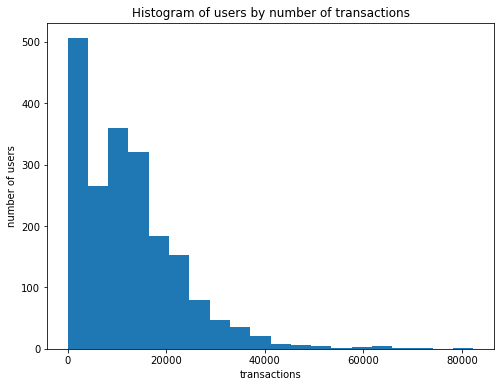

In [25]:
# Quick look at how the transactions are distributed amongst users
plt.figure(figsize=(8, 6))
trans_df.User.value_counts().plot(kind='hist', bins=20, ylabel='transactions', 
                                  title='Histogram of users by number of transactions');
plt.xlabel('transactions')
plt.ylabel('number of users')
plt.show()

So most users have a relatively low number of transactions, and very few users a high number of transactions.

In [26]:
trans_df.shape

(24386900, 15)

### Inspection of the target feature 'Is Fraud?'

In [27]:
trans_df['Is Fraud?'].value_counts()

No     24357143
Yes       29757
Name: Is Fraud?, dtype: int64

In [28]:
100*trans_df['Is Fraud?'].value_counts(normalize=True)

No     99.87798
Yes     0.12202
Name: Is Fraud?, dtype: float64

Clearly massive class imbalance here as we would expect in a dataset where fraudulent transactions should represent a tiny proportion of all transactions.

### Subsetting the transaction data
24 million transactions is too many to deal with.  Also, as can be seen above, I have massive class imbalance.  What I would like to do is end up with 10,000 transactions with 50:50 class balance which will make model training much more straightforward.  So I'm going to take about one sixth of the data which will give me 5000 fraud transaction and ~4M transactions in total.  I can then undersample the majority class to end up with 5000 non-fraud transactions and a 50/50 split.  But before I do the undersampling I may want to apply some time-series shifted columns, etc.  This will effectively retain key elements of the rows of data which will have been removed via sub-sampling.

In [29]:
# 336 users would in theory retain 5000 fraud records, but of course the amount of fraud per user is not completely uniform. So
# here I have 'tweaked' the maximum User (id) I retain until I have exactly 5000 fraud records.
trans_df[trans_df.User < 373]['Is Fraud?'].value_counts()

No     4460569
Yes       5000
Name: Is Fraud?, dtype: int64

In [30]:
sub_trans_df = trans_df[trans_df.User < 373].copy()

In [31]:
sub_trans_df.shape

(4465569, 15)

In [32]:
sub_trans_df.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No


In [33]:
# delete original transaction data frame
del(trans_df)

### Creation of timestamp column

In [34]:
# Add hour and minute columns for creating datetime, and also hour column could be a useful feature.
# We will need a datetime for data sorting later on.
sub_trans_df[['Hour','Minute']] = sub_trans_df.Time.str.split(':',expand=True)

In [35]:
# check that's worked
sub_trans_df.columns

Index(['User', 'Card', 'Year', 'Month', 'Day', 'Time', 'Amount', 'Use Chip',
       'Merchant Name', 'Merchant City', 'Merchant State', 'Zip', 'MCC',
       'Errors?', 'Is Fraud?', 'Hour', 'Minute'],
      dtype='object')

In [36]:
sub_trans_df.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,Hour,Minute
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No,06,21
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No,06,42
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No,06,22
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No,17,45
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No,06,23


In [37]:
# Create the timestamp column, "date_time"
sub_trans_df['date_time'] = pd.to_datetime(sub_trans_df[['Day','Month','Year','Hour','Minute']])

In [38]:
# Check that too
sub_trans_df.head(3)

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,Hour,Minute,date_time
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No,06,21,2002-09-01 06:21:00
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No,06,42,2002-09-01 06:42:00
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No,06,22,2002-09-02 06:22:00


### Dealing with NULL values

In [39]:
# Use my EDA class to see how many nulls I have and where they are
sub_trans_eda = Eda(sub_trans_df)

In [40]:
sub_trans_eda.report_nulls()

Total nulls in data frame is:  5476096
4403904  out of  4465569 rows have nulls in one or more column
Errors?           4391314
Zip                558170
Merchant State     526612
dtype: int64


#### Errors? feature

In [41]:
# Let's look at Errors? first.  Which values appear in the "Errors?" feature?
sub_trans_df['Errors?'].value_counts(dropna=False)

NaN                                                4391314
Insufficient Balance                                 46894
Bad PIN                                              10994
Technical Glitch                                      8910
Bad Card Number                                       2522
Bad Expiration                                        2186
Bad CVV                                               2088
Bad Zipcode                                            335
Insufficient Balance,Technical Glitch                   99
Bad PIN,Insufficient Balance                            95
Bad PIN,Technical Glitch                                30
Bad CVV,Insufficient Balance                            18
Bad Card Number,Bad CVV                                 16
Bad Card Number,Insufficient Balance                    15
Bad Expiration,Insufficient Balance                     14
Bad Card Number,Bad Expiration                          13
Bad Expiration,Bad CVV                                  

In [42]:
# Peruse where Errors? is null
sub_trans_df.loc[sub_trans_df['Errors?'].isnull() == True]

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,Hour,Minute,date_time
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No,06,21,2002-09-01 06:21:00
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No,06,42,2002-09-01 06:42:00
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No,06,22,2002-09-02 06:22:00
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No,17,45,2002-09-02 17:45:00
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No,06,23,2002-09-03 06:23:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4465564,372,0,2020,2,27,21:51,$41.46,Chip Transaction,2117224408045100966,Ninety Six,SC,29666.0,4900,NaN,No,21,51,2020-02-27 21:51:00
4465565,372,0,2020,2,28,11:15,$9.46,Chip Transaction,5817218446178736267,Pendleton,SC,29670.0,5912,NaN,No,11,15,2020-02-28 11:15:00
4465566,372,0,2020,2,28,18:56,$47.75,Chip Transaction,-6035332392926029059,Ninety Six,SC,29666.0,5812,NaN,No,18,56,2020-02-28 18:56:00
4465567,372,0,2020,2,28,23:07,$135.00,Chip Transaction,-1007477596717646975,Marysville,OH,43040.0,3780,NaN,No,23,07,2020-02-28 23:07:00


In [43]:
# So "normal" transactions look to be where Errors? is set to null.  So let's set it to something meaningful instead.
sub_trans_df['Errors?'].fillna('No error', inplace=True)

In [44]:
# check that's worked
sub_trans_df['Errors?'].value_counts(dropna=False)

No error                                           4391314
Insufficient Balance                                 46894
Bad PIN                                              10994
Technical Glitch                                      8910
Bad Card Number                                       2522
Bad Expiration                                        2186
Bad CVV                                               2088
Bad Zipcode                                            335
Insufficient Balance,Technical Glitch                   99
Bad PIN,Insufficient Balance                            95
Bad PIN,Technical Glitch                                30
Bad CVV,Insufficient Balance                            18
Bad Card Number,Bad CVV                                 16
Bad Card Number,Insufficient Balance                    15
Bad Expiration,Insufficient Balance                     14
Bad Card Number,Bad Expiration                          13
Bad Expiration,Bad CVV                                  

Let's take a look at how prevalent fraud is on each of the error types.

In [45]:
# create a small data frame breaking down the fraud occuring with each type of error.
errors_df = sub_trans_df.groupby(['Errors?'])['Is Fraud?'].value_counts(normalize=True, sort=False).to_frame(name='percentages')
errors_df.reset_index(inplace=True)
errors_df.percentages = errors_df.percentages*100

In [46]:
errors_df.head(4)

,Errors?,Is Fraud?,percentages
0,Bad CVV,No,97.892720
1,Bad CVV,Yes,2.107280
2,"Bad CVV,Insufficient Balance",No,94.444444
3,"Bad CVV,Insufficient Balance",Yes,5.555556


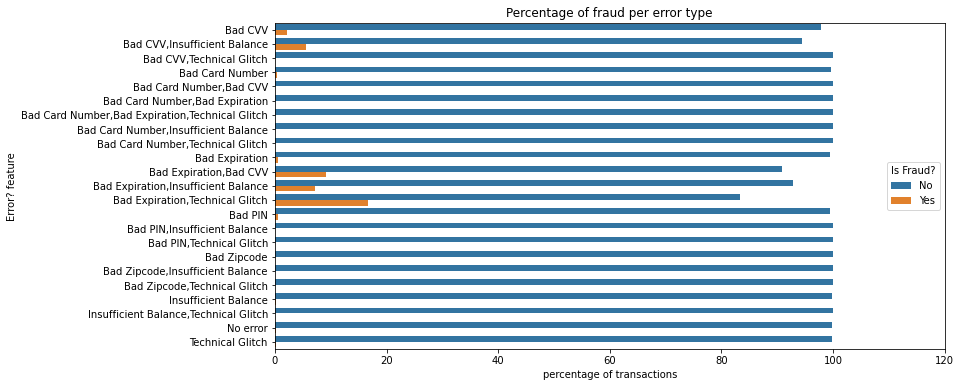

In [47]:
plt.figure(figsize=(12, 6))
sns.barplot(data=errors_df, x='percentages', y='Errors?', hue='Is Fraud?', orient='h')
plt.xlabel('percentage of transactions')
plt.ylabel('Error? feature')
plt.title('Percentage of fraud per error type')
plt.xlim(0,120)
plt.show()

From here we can see that certain error types strongly suggest fraud, so we could use these as a predictor.  Recalling that our baseline level of fraud is very low (0.12202%), which error codes have more fraud than this?

In [48]:
high_fraud_error_codes = errors_df[(errors_df['Is Fraud?'] == 'Yes') & (errors_df['percentages'] > 0.12202)]['Errors?'].values
high_fraud_error_codes

array(['Bad CVV', 'Bad CVV,Insufficient Balance', 'Bad Card Number',
       'Bad Expiration', 'Bad Expiration,Bad CVV',
       'Bad Expiration,Insufficient Balance',
       'Bad Expiration,Technical Glitch', 'Bad PIN',
       'Insufficient Balance', 'Technical Glitch'], dtype=object)

In [49]:
# create feature "fraud_error" which will be set to 'Yes' for transactions with a higher likelihood of fraud.
sub_trans_df['fraud_error'] = 'No'
sub_trans_df.loc[sub_trans_df['Errors?'].isin(high_fraud_error_codes),'fraud_error'] = 'Yes'

In [50]:
# Quick check that's worked as expected.
sub_trans_df[sub_trans_df.fraud_error == 'Yes']['Errors?'].unique()

array(['Technical Glitch', 'Insufficient Balance', 'Bad PIN',
       'Bad Expiration', 'Bad Card Number', 'Bad CVV',
       'Bad CVV,Insufficient Balance', 'Bad Expiration,Bad CVV',
       'Bad Expiration,Insufficient Balance',
       'Bad Expiration,Technical Glitch'], dtype=object)

#### Zip, Merchant State and online transactions

In [51]:
sub_trans_eda.report_nulls()

Total nulls in data frame is:  1084782
558170  out of  4465569 rows have nulls in one or more column
Zip               558170
Merchant State    526612
dtype: int64


In [52]:
# Let's take a look at when Merchant State is null
sub_trans_df[sub_trans_df['Merchant State'].isnull() == True]

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,Hour,Minute,date_time,fraud_error
11,0,0,2002,9,5,20:41,$53.91,Online Transaction,-9092677072201095172,ONLINE,NaN,NaN,4900,No error,No,20,41,2002-09-05 20:41:00,No
24,0,0,2002,9,9,20:02,$144.90,Online Transaction,-8338381919281017248,ONLINE,NaN,NaN,4899,No error,No,20,02,2002-09-09 20:02:00,No
85,0,0,2002,9,30,06:21,$127.32,Online Transaction,-7421093378627544099,ONLINE,NaN,NaN,5311,No error,No,06,21,2002-09-30 06:21:00,No
99,0,0,2002,10,6,06:14,$139.39,Online Transaction,-7421093378627544099,ONLINE,NaN,NaN,5311,No error,No,06,14,2002-10-06 06:14:00,No
106,0,0,2002,10,9,08:16,$53.09,Online Transaction,-4956618006720593695,ONLINE,NaN,NaN,5193,No error,No,08,16,2002-10-09 08:16:00,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4465485,372,0,2020,1,25,09:37,$53.43,Online Transaction,1698045825511338540,ONLINE,NaN,NaN,7922,No error,No,09,37,2020-01-25 09:37:00,No
4465504,372,0,2020,2,6,12:08,$119.95,Online Transaction,4241336128694185533,ONLINE,NaN,NaN,4814,No error,No,12,08,2020-02-06 12:08:00,No
4465526,372,0,2020,2,13,19:55,$67.87,Online Transaction,7035602569409149834,ONLINE,NaN,NaN,5311,No error,No,19,55,2020-02-13 19:55:00,No
4465530,372,0,2020,2,15,12:01,$102.39,Online Transaction,4241336128694185533,ONLINE,NaN,NaN,4814,No error,No,12,01,2020-02-15 12:01:00,No


Note how Merchant City appears to be "ONLINE".  Could these all be online transactions?  Let's have a look at that.  Also I note that Zip appears to be null for these transactions too.

In [53]:
sub_trans_df[sub_trans_df['Merchant State'].isnull() == True]['Merchant City'].unique()

array(['ONLINE'], dtype=object)

Also noticing that "Use Chip" indicates an online transaction too.  I wonder what the other values of "Use Chip" are ...

In [54]:
sub_trans_df['Use Chip'].unique()

array(['Swipe Transaction', 'Online Transaction', 'Chip Transaction'],
      dtype=object)

So let's just check and see if Merchant City is always "ONLINE" for 'Use Chip' of 'Online Transaction'


In [55]:
sub_trans_df[sub_trans_df['Use Chip'] == 'Online Transaction']['Merchant City'].unique()

array(['ONLINE'], dtype=object)

So we can safely say that Merchant City reliably indicates online transactions.  And if Merchant City always says "ONLINE" when Merchant State is null, then we may as well fill the nulls with "ONLINE" too.

In [56]:
sub_trans_df['Merchant State'].fillna('ONLINE', inplace=True)

In [57]:
# check that's worked.
sub_trans_df['Merchant State'].value_counts()

ONLINE          526612
TX              433352
CA              396785
FL              303404
NY              217124
                 ...  
Panama               2
Honduras             2
Kiribati             1
Samoa                1
Sierra Leone         1
Name: Merchant State, Length: 158, dtype: int64

So, back to Zip codes.  Let's see if they were always null for online transactions.

In [58]:
sub_trans_df[sub_trans_df['Merchant State'] == 'ONLINE'].Zip.value_counts(dropna=False)

NaN    526612
Name: Zip, dtype: int64

OK, so this looks like most of the null Zips, but what are the rest ...

In [59]:
# Look at non-online transactions with a null zip code.
sub_trans_df[(sub_trans_df['Merchant State'] != 'ONLINE') & (sub_trans_df['Zip'].isnull() == True)]

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,Hour,Minute,date_time,fraud_error
407,0,0,2003,2,24,13:02,$7.52,Swipe Transaction,-727612092139916043,Zurich,Switzerland,NaN,5411,No error,No,13,02,2003-02-24 13:02:00,No
408,0,0,2003,2,25,06:46,$36.97,Swipe Transaction,-4816289482172287511,Zurich,Switzerland,NaN,5411,No error,No,06,46,2003-02-25 06:46:00,No
906,0,0,2004,7,22,06:32,$38.26,Swipe Transaction,3510944833163794547,Tallinn,Estonia,NaN,5912,No error,No,06,32,2004-07-22 06:32:00,No
907,0,0,2004,7,23,20:05,$75.38,Swipe Transaction,8793545055147237096,Tallinn,Estonia,NaN,5812,No error,No,20,05,2004-07-23 20:05:00,No
908,0,0,2004,7,25,13:08,$16.20,Swipe Transaction,2027553650310142703,Tallinn,Estonia,NaN,5541,No error,No,13,08,2004-07-25 13:08:00,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4457670,372,0,2010,10,10,13:27,$147.74,Swipe Transaction,-2721010215344241647,Beijing,China,NaN,7011,No error,No,13,27,2010-10-10 13:27:00,No
4458422,372,0,2011,8,23,04:16,$345.00,Swipe Transaction,-7807051024009846392,Shanghai,China,NaN,3684,No error,No,04,16,2011-08-23 04:16:00,No
4458426,372,0,2011,8,23,19:11,$31.77,Swipe Transaction,-2744911404133435018,Shanghai,China,NaN,5812,No error,No,19,11,2011-08-23 19:11:00,No
4458427,372,0,2011,8,24,04:50,$-345.00,Swipe Transaction,-7807051024009846392,Shanghai,China,NaN,3684,No error,No,04,50,2011-08-24 04:50:00,No


In [60]:
# So these look like foreign transactions.  Let's look at 'Merchant State' for all of them.
sub_trans_df[(sub_trans_df['Merchant State'] != 'ONLINE') & (sub_trans_df['Zip'].isnull() == True)]['Merchant State'].unique()

array(['Switzerland', 'Estonia', 'Japan', 'Mexico', 'Dominican Republic',
       'China', 'Portugal', 'Italy', 'Philippines', 'Jamaica', 'Canada',
       'France', 'Norway', 'New Zealand', 'Netherlands', 'Sierra Leone',
       'Haiti', 'South Korea', 'Spain', 'Algeria', 'Egypt', 'Indonesia',
       'United Kingdom', 'Colombia', 'South Africa', 'The Bahamas',
       'Singapore', 'Pakistan', 'Malaysia', 'Mongolia', 'Israel',
       'Hong Kong', 'Guatemala', 'Peru', 'Thailand', 'Sweden', 'Taiwan',
       'Germany', 'Czech Republic', 'India', 'Poland', 'Costa Rica',
       'Denmark', 'Bangladesh', 'Macedonia', 'Nigeria', 'Tuvalu',
       'Ireland', 'Vatican City', 'Lithuania', 'Papua New Guinea',
       'Belgium', 'Benin', 'Croatia', 'Saudi Arabia', 'Latvia', 'Austria',
       'Slovenia', 'Turkey', 'Russia', 'Greece', 'Slovakia', 'Brazil',
       'Hungary', 'Argentina', 'Serbia', 'Ghana', 'Oman',
       'United Arab Emirates', 'Finland', 'Barbados', 'Australia',
       'Vietnam', 'Micrones

So another useful feature we can create here is an "abroad" flag to mark these transactions.

In [61]:
sub_trans_df['abroad'] = 'No'
sub_trans_df.loc[(sub_trans_df['Merchant State'] != 'ONLINE') & (sub_trans_df['Zip'].isnull() == True), 'abroad'] = 'Yes'

In [62]:
# check on that
sub_trans_df.abroad.value_counts()

No     4434011
Yes      31558
Name: abroad, dtype: int64

In [63]:
sub_trans_df[sub_trans_df.abroad == 'Yes']['Merchant State'].value_counts().head(10)

Mexico                9598
Canada                4243
Italy                 1807
United Kingdom        1747
China                 1205
France                1163
Germany               1108
Japan                  724
India                  662
Dominican Republic     627
Name: Merchant State, dtype: int64

Lastly we want to fill the nulls in Zip.  We will use the current mean value so as not to disrupt any other potential
'signal' which the field might carry.

In [64]:
mean_zip_value = round(sub_trans_df.Zip.mean(),1)
mean_zip_value

53899.9

The fact this ends with '.9' will be a good visual aid memoir if scanning through values later.  Now let's fill null Zips.

In [65]:
sub_trans_df.Zip.fillna(mean_zip_value, inplace=True)

In [66]:
# check on that.
sub_trans_df[sub_trans_df.Zip == mean_zip_value].Zip.count()

558170

This matches the number of nulls we started with so all good.  Final check for nulls.

In [67]:
sub_trans_df.isnull().sum().sum()

0

Before we move on, let's create an explicit flag for online transactions to use for further EDA and modelling ...

In [68]:
sub_trans_df['online'] = 'No'
sub_trans_df.loc[sub_trans_df['Merchant State'] == 'ONLINE','online'] = 'Yes'

In [69]:
# check counts are as expected
sub_trans_df.online.value_counts()

No     3938957
Yes     526612
Name: online, dtype: int64

### Resolving data types

In [70]:
sub_trans_df.head(1)

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,Hour,Minute,date_time,fraud_error,abroad,online
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,No error,No,06,21,2002-09-01 06:21:00,No,No,No


In [71]:
sub_trans_df.dtypes

User                       int64
Card                       int64
Year                       int64
Month                      int64
Day                        int64
Time                      object
Amount                    object
Use Chip                  object
Merchant Name              int64
Merchant City             object
Merchant State            object
Zip                      float64
MCC                        int64
Errors?                   object
Is Fraud?                 object
Hour                      object
Minute                    object
date_time         datetime64[ns]
fraud_error               object
abroad                    object
online                    object
dtype: object

Amount needs sorting here - it should be a float.  We need to remove the $ sign.

In [72]:
# Remove $ sign
sub_trans_df.Amount = sub_trans_df.Amount.str.replace('$','', regex=False)

In [73]:
# Change type to float
sub_trans_df.Amount = sub_trans_df.Amount.astype(float)

In [74]:
# quick check
sub_trans_df.dtypes.loc['Amount']

dtype('float64')

## Loading and cleaning the users data

In [75]:
users_df = pd.read_csv('~/GA/capstone2-data/sd254_users.csv')
users_df.head()

,Person,Current Age,Retirement Age,Birth Year,Birth Month,Gender,Address,Apartment,City,State,Zipcode,Latitude,Longitude,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards
0,Hazel Robinson,53,66,1966,11,Female,462 Rose Lane,NaN,La Verne,CA,91750,34.15,-117.76,$29278,$59696,$127613,787,5
1,Sasha Sadr,53,68,1966,12,Female,3606 Federal Boulevard,NaN,Little Neck,NY,11363,40.76,-73.74,$37891,$77254,$191349,701,5
2,Saanvi Lee,81,67,1938,11,Female,766 Third Drive,NaN,West Covina,CA,91792,34.02,-117.89,$22681,$33483,$196,698,5
3,Everlee Clark,63,63,1957,1,Female,3 Madison Street,NaN,New York,NY,10069,40.71,-73.99,$163145,$249925,$202328,722,4
4,Kyle Peterson,43,70,1976,9,Male,9620 Valley Stream Drive,NaN,San Francisco,CA,94117,37.76,-122.44,$53797,$109687,$183855,675,1


In [76]:
# Create User field (same as index) for clarity when joining to transactions.
users_df['User'] = users_df.index

In [77]:
# Check that worked as expected.
users_df.head(2)

,Person,Current Age,Retirement Age,Birth Year,Birth Month,Gender,Address,Apartment,City,State,Zipcode,Latitude,Longitude,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards,User
0,Hazel Robinson,53,66,1966,11,Female,462 Rose Lane,NaN,La Verne,CA,91750,34.15,-117.76,$29278,$59696,$127613,787,5,0
1,Sasha Sadr,53,68,1966,12,Female,3606 Federal Boulevard,NaN,Little Neck,NY,11363,40.76,-73.74,$37891,$77254,$191349,701,5,1


### Dealing with Null values

In [78]:
users_df.isnull().sum()

Person                            0
Current Age                       0
Retirement Age                    0
Birth Year                        0
Birth Month                       0
Gender                            0
Address                           0
Apartment                      1472
City                              0
State                             0
Zipcode                           0
Latitude                          0
Longitude                         0
Per Capita Income - Zipcode       0
Yearly Income - Person            0
Total Debt                        0
FICO Score                        0
Num Credit Cards                  0
User                              0
dtype: int64

In [79]:
# See what's in appartment
users_df.Apartment.value_counts(dropna=False)

NaN       1472
2.0         32
1.0         31
6.0         30
8.0         29
          ... 
4775.0       1
455.0        1
6545.0       1
22.0         1
955.0        1
Name: Apartment, Length: 200, dtype: int64

In [80]:
# See what the minimum value is
users_df.Apartment.min()

1.0

In [81]:
# So let's set to 0 when Apartment is null, but let's keep whether someone has an apartment number or not as a feature too.
users_df['apartment_set'] = 'Yes'
users_df.loc[users_df.Apartment.isnull() == True, 'apartment_set'] = 'No'

In [82]:
users_df.apartment_set.value_counts()

No     1472
Yes     528
Name: apartment_set, dtype: int64

In [83]:
# Now set it to 0 when it's null
users_df.fillna(0, inplace=True)

In [84]:
users_df.isnull().sum().sum()

0

### Resolving data types

In [85]:
users_df.head(1)

,Person,Current Age,Retirement Age,Birth Year,Birth Month,Gender,Address,Apartment,City,State,Zipcode,Latitude,Longitude,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards,User,apartment_set
0,Hazel Robinson,53,66,1966,11,Female,462 Rose Lane,0.0,La Verne,CA,91750,34.15,-117.76,$29278,$59696,$127613,787,5,0,No


In [86]:
users_df.dtypes

Person                          object
Current Age                      int64
Retirement Age                   int64
Birth Year                       int64
Birth Month                      int64
Gender                          object
Address                         object
Apartment                      float64
City                            object
State                           object
Zipcode                          int64
Latitude                       float64
Longitude                      float64
Per Capita Income - Zipcode     object
Yearly Income - Person          object
Total Debt                      object
FICO Score                       int64
Num Credit Cards                 int64
User                             int64
apartment_set                   object
dtype: object

So here, per capita income, yearly income and total debt need migrating to floats.

In [87]:
users_df['Per Capita Income - Zipcode'] = users_df['Per Capita Income - Zipcode'].str.replace('$','',regex=False).astype(float)

In [88]:
users_df['Yearly Income - Person'] = users_df['Yearly Income - Person'].str.replace('$','',regex=False).astype(float)

In [89]:
users_df['Total Debt'] = users_df['Total Debt'].str.replace('$','',regex=False).astype(float)

In [90]:
# check results
users_df.head()

,Person,Current Age,Retirement Age,Birth Year,Birth Month,Gender,Address,Apartment,City,State,Zipcode,Latitude,Longitude,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards,User,apartment_set
0,Hazel Robinson,53,66,1966,11,Female,462 Rose Lane,0.0,La Verne,CA,91750,34.15,-117.76,29278.0,59696.0,127613.0,787,5,0,No
1,Sasha Sadr,53,68,1966,12,Female,3606 Federal Boulevard,0.0,Little Neck,NY,11363,40.76,-73.74,37891.0,77254.0,191349.0,701,5,1,No
2,Saanvi Lee,81,67,1938,11,Female,766 Third Drive,0.0,West Covina,CA,91792,34.02,-117.89,22681.0,33483.0,196.0,698,5,2,No
3,Everlee Clark,63,63,1957,1,Female,3 Madison Street,0.0,New York,NY,10069,40.71,-73.99,163145.0,249925.0,202328.0,722,4,3,No
4,Kyle Peterson,43,70,1976,9,Male,9620 Valley Stream Drive,0.0,San Francisco,CA,94117,37.76,-122.44,53797.0,109687.0,183855.0,675,1,4,No


In [91]:
users_df.dtypes

Person                          object
Current Age                      int64
Retirement Age                   int64
Birth Year                       int64
Birth Month                      int64
Gender                          object
Address                         object
Apartment                      float64
City                            object
State                           object
Zipcode                          int64
Latitude                       float64
Longitude                      float64
Per Capita Income - Zipcode    float64
Yearly Income - Person         float64
Total Debt                     float64
FICO Score                       int64
Num Credit Cards                 int64
User                             int64
apartment_set                   object
dtype: object

## Loading and cleaning cards data

In [92]:
cards_df = pd.read_csv('~/GA/capstone2-data/sd254_cards.csv')

In [93]:
cards_df.head(10)

,User,CARD INDEX,Card Brand,Card Type,Card Number,Expires,CVV,Has Chip,Cards Issued,Credit Limit,Acct Open Date,Year PIN last Changed,Card on Dark Web
0,0,0,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,0,1,Visa,Debit,4956965974959986,12/2020,393,YES,2,$21968,04/2014,2014,No
2,0,2,Visa,Debit,4582313478255491,02/2024,719,YES,2,$46414,07/2003,2004,No
3,0,3,Visa,Credit,4879494103069057,08/2024,693,NO,1,$12400,01/2003,2012,No
4,0,4,Mastercard,Debit (Prepaid),5722874738736011,03/2009,75,YES,1,$28,09/2008,2009,No
5,1,0,Visa,Credit,4404898874682993,09/2003,736,YES,1,$27500,09/2003,2012,No
6,1,1,Visa,Debit,4001482973848631,07/2022,972,YES,2,$28508,02/2011,2011,No
7,1,2,Mastercard,Debit,5627220683410948,06/2022,48,YES,2,$9022,07/2003,2015,No
8,1,3,Mastercard,Debit (Prepaid),5711382187309326,11/2020,722,YES,2,$54,06/2010,2015,No
9,1,4,Mastercard,Debit (Prepaid),5766121508358701,02/2023,908,YES,1,$99,07/2006,2012,No


In [94]:
# Check there are no nulls
cards_df.isnull().sum().sum()

0

In [95]:
# Have a quick look at the distribution of 'Cards Issued'
cards_df['Cards Issued'].value_counts()

1    3114
2    2972
3      60
Name: Cards Issued, dtype: int64

### Resolving data types

In [96]:
cards_df.dtypes

User                      int64
CARD INDEX                int64
Card Brand               object
Card Type                object
Card Number               int64
Expires                  object
CVV                       int64
Has Chip                 object
Cards Issued              int64
Credit Limit             object
Acct Open Date           object
Year PIN last Changed     int64
Card on Dark Web         object
dtype: object

So credit limit needs converting to a float.  Card expiry date ("Expires") and "Acct Open Date" should also be mapped to dates.

In [97]:
cards_df['Credit Limit'] = cards_df['Credit Limit'].str.replace('$','', regex=False).astype(float)

In [98]:
# check on that
cards_df.head(1)

,User,CARD INDEX,Card Brand,Card Type,Card Number,Expires,CVV,Has Chip,Cards Issued,Credit Limit,Acct Open Date,Year PIN last Changed,Card on Dark Web
0,0,0,Visa,Debit,4344676511950444,12/2022,623,YES,2,24295.0,09/2002,2008,No


In [99]:
cards_df.dtypes.loc['Credit Limit']

dtype('float64')

Let's also convert "Expires" and "Acct Open Date" to ordinals for modelling.

In [100]:
cards_df['Acct Open Date'] = pd.to_datetime(cards_df['Acct Open Date'], format="%m/%Y" ).map(datetime.toordinal)

In [101]:
cards_df['Expires'] = pd.to_datetime(cards_df['Expires'], format="%m/%Y" ).map(datetime.toordinal)

In [102]:
cards_df.head(3)

,User,CARD INDEX,Card Brand,Card Type,Card Number,Expires,CVV,Has Chip,Cards Issued,Credit Limit,Acct Open Date,Year PIN last Changed,Card on Dark Web
0,0,0,Visa,Debit,4344676511950444,738490,623,YES,2,24295.0,731094,2008,No
1,0,1,Visa,Debit,4956965974959986,737760,393,YES,2,21968.0,735324,2014,No
2,0,2,Visa,Debit,4582313478255491,738917,719,YES,2,46414.0,731397,2004,No


## Joining up transaction, user and card data
### Column re-naming
I have re-named columns, giving each a prefix based on the data file it came from.  Index key columns have been kept the same to allow merging to take place.

In [103]:
# Re-name transaction df columns.  Put a "tx_" on the front and loose spaces and "?"
trans_col_map={col:f'tx_{(col.lower().replace(" ","_").replace("?",""))}' for col in sub_trans_df.columns}
# user_id and card need to be set to the same column names across all dfs for merging
trans_col_map['User'] = 'user_id'
trans_col_map['Card'] = 'card'
trans_col_map

{'User': 'user_id',
 'Card': 'card',
 'Year': 'tx_year',
 'Month': 'tx_month',
 'Day': 'tx_day',
 'Time': 'tx_time',
 'Amount': 'tx_amount',
 'Use Chip': 'tx_use_chip',
 'Merchant Name': 'tx_merchant_name',
 'Merchant City': 'tx_merchant_city',
 'Merchant State': 'tx_merchant_state',
 'Zip': 'tx_zip',
 'MCC': 'tx_mcc',
 'Errors?': 'tx_errors',
 'Is Fraud?': 'tx_is_fraud',
 'Hour': 'tx_hour',
 'Minute': 'tx_minute',
 'date_time': 'tx_date_time',
 'fraud_error': 'tx_fraud_error',
 'abroad': 'tx_abroad',
 'online': 'tx_online'}

In [104]:
# Note of additional cols in the above
# 'Hour': 'tx_hour',
#  'Minute': 'tx_minute',
#  'date_time': 'tx_date_time',
#  'fraud_error': 'tx_fraud_error',
#  'abroad': 'tx_abroad',
#  'online': 'tx_online'

In [105]:
sub_trans_df.rename(columns=trans_col_map, inplace=True)

In [106]:
users_col_map={col:f'usr_{(col.lower().replace(" ","_").replace("?","")).replace("-_","")}' for col in users_df.columns}
users_col_map['User'] = 'user_id'
users_col_map

{'Person': 'usr_person',
 'Current Age': 'usr_current_age',
 'Retirement Age': 'usr_retirement_age',
 'Birth Year': 'usr_birth_year',
 'Birth Month': 'usr_birth_month',
 'Gender': 'usr_gender',
 'Address': 'usr_address',
 'Apartment': 'usr_apartment',
 'City': 'usr_city',
 'State': 'usr_state',
 'Zipcode': 'usr_zipcode',
 'Latitude': 'usr_latitude',
 'Longitude': 'usr_longitude',
 'Per Capita Income - Zipcode': 'usr_per_capita_income_zipcode',
 'Yearly Income - Person': 'usr_yearly_income_person',
 'Total Debt': 'usr_total_debt',
 'FICO Score': 'usr_fico_score',
 'Num Credit Cards': 'usr_num_credit_cards',
 'User': 'user_id',
 'apartment_set': 'usr_apartment_set'}

In [107]:
users_df.rename(columns=users_col_map, inplace=True)

In [108]:
cards_col_map={col:f'cc_{(col.lower().replace(" ","_").replace("?",""))}' for col in cards_df.columns}
cards_col_map['User'] = 'user_id'
cards_col_map['CARD INDEX'] = 'card'
cards_col_map

{'User': 'user_id',
 'CARD INDEX': 'card',
 'Card Brand': 'cc_card_brand',
 'Card Type': 'cc_card_type',
 'Card Number': 'cc_card_number',
 'Expires': 'cc_expires',
 'CVV': 'cc_cvv',
 'Has Chip': 'cc_has_chip',
 'Cards Issued': 'cc_cards_issued',
 'Credit Limit': 'cc_credit_limit',
 'Acct Open Date': 'cc_acct_open_date',
 'Year PIN last Changed': 'cc_year_pin_last_changed',
 'Card on Dark Web': 'cc_card_on_dark_web'}

In [109]:
cards_df.rename(columns=cards_col_map, inplace=True)

In [110]:
sub_trans_df.columns

Index(['user_id', 'card', 'tx_year', 'tx_month', 'tx_day', 'tx_time',
       'tx_amount', 'tx_use_chip', 'tx_merchant_name', 'tx_merchant_city',
       'tx_merchant_state', 'tx_zip', 'tx_mcc', 'tx_errors', 'tx_is_fraud',
       'tx_hour', 'tx_minute', 'tx_date_time', 'tx_fraud_error', 'tx_abroad',
       'tx_online'],
      dtype='object')

In [111]:
users_df.columns

Index(['usr_person', 'usr_current_age', 'usr_retirement_age', 'usr_birth_year',
       'usr_birth_month', 'usr_gender', 'usr_address', 'usr_apartment',
       'usr_city', 'usr_state', 'usr_zipcode', 'usr_latitude', 'usr_longitude',
       'usr_per_capita_income_zipcode', 'usr_yearly_income_person',
       'usr_total_debt', 'usr_fico_score', 'usr_num_credit_cards', 'user_id',
       'usr_apartment_set'],
      dtype='object')

In [112]:
cards_df.columns

Index(['user_id', 'card', 'cc_card_brand', 'cc_card_type', 'cc_card_number',
       'cc_expires', 'cc_cvv', 'cc_has_chip', 'cc_cards_issued',
       'cc_credit_limit', 'cc_acct_open_date', 'cc_year_pin_last_changed',
       'cc_card_on_dark_web'],
      dtype='object')

### Joining the data sets

In [113]:
# delete if it already exists from previous runs
#del(tx_and_usr_df)

In [114]:
# Join transactions to users by user_id
tx_and_usr_df = pd.merge(left=sub_trans_df, right=users_df, how='left', on='user_id')

In [115]:
# join transactions to credit cards by used_id and card number
tx_aug_df = pd.merge(left=tx_and_usr_df, right=cards_df, how='left', on=['user_id','card'])

In [116]:
# check the join by looking for nulls and making sure we only find them where we expect them.
tx_aug_df.isnull().sum()

user_id                          0
card                             0
tx_year                          0
tx_month                         0
tx_day                           0
tx_time                          0
tx_amount                        0
tx_use_chip                      0
tx_merchant_name                 0
tx_merchant_city                 0
tx_merchant_state                0
tx_zip                           0
tx_mcc                           0
tx_errors                        0
tx_is_fraud                      0
tx_hour                          0
tx_minute                        0
tx_date_time                     0
tx_fraud_error                   0
tx_abroad                        0
tx_online                        0
usr_person                       0
usr_current_age                  0
usr_retirement_age               0
usr_birth_year                   0
usr_birth_month                  0
usr_gender                       0
usr_address                      0
usr_apartment       

In [117]:
# check on target feature
tx_aug_df.tx_is_fraud.value_counts()

No     4460569
Yes       5000
Name: tx_is_fraud, dtype: int64

In [118]:
tx_aug_df.head(50)

,user_id,card,tx_year,tx_month,tx_day,tx_time,tx_amount,tx_use_chip,tx_merchant_name,tx_merchant_city,tx_merchant_state,tx_zip,tx_mcc,tx_errors,tx_is_fraud,tx_hour,tx_minute,tx_date_time,tx_fraud_error,tx_abroad,tx_online,usr_person,usr_current_age,usr_retirement_age,usr_birth_year,usr_birth_month,usr_gender,usr_address,usr_apartment,usr_city,usr_state,usr_zipcode,usr_latitude,usr_longitude,usr_per_capita_income_zipcode,usr_yearly_income_person,usr_total_debt,usr_fico_score,usr_num_credit_cards,usr_apartment_set,cc_card_brand,cc_card_type,cc_card_number,cc_expires,cc_cvv,cc_has_chip,cc_cards_issued,cc_credit_limit,cc_acct_open_date,cc_year_pin_last_changed,cc_card_on_dark_web
0,0,0,2002,9,1,06:21,134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,No error,No,06,21,2002-09-01 06:21:00,No,No,No,Hazel Robinson,53,66,1966,11,Female,462 Rose Lane,0.0,La Verne,CA,91750,34.15,-117.76,29278.0,59696.0,127613.0,787,5,No,Visa,Debit,4344676511950444,738490,623,YES,2,24295.0,731094,2008,No
1,0,0,2002,9,1,06:42,38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,No error,No,06,42,2002-09-01 06:42:00,No,No,No,Hazel Robinson,53,66,1966,11,Female,462 Rose Lane,0.0,La Verne,CA,91750,34.15,-117.76,29278.0,59696.0,127613.0,787,5,No,Visa,Debit,4344676511950444,738490,623,YES,2,24295.0,731094,2008,No
2,0,0,2002,9,2,06:22,120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,No error,No,06,22,2002-09-02 06:22:00,No,No,No,Hazel Robinson,53,66,1966,11,Female,462 Rose Lane,0.0,La Verne,CA,91750,34.15,-117.76,29278.0,59696.0,127613.0,787,5,No,Visa,Debit,4344676511950444,738490,623,YES,2,24295.0,731094,2008,No
3,0,0,2002,9,2,17:45,128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,No error,No,17,45,2002-09-02 17:45:00,No,No,No,Hazel Robinson,53,66,1966,11,Female,462 Rose Lane,0.0,La Verne,CA,91750,34.15,-117.76,29278.0,59696.0,127613.0,787,5,No,Visa,Debit,4344676511950444,738490,623,YES,2,24295.0,731094,2008,No
4,0,0,2002,9,3,06:23,104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,No error,No,06,23,2002-09-03 06:23:00,No,No,No,Hazel Robinson,53,66,1966,11,Female,462 Rose Lane,0.0,La Verne,CA,91750,34.15,-117.76,29278.0,59696.0,127613.0,787,5,No,Visa,Debit,4344676511950444,738490,623,YES,2,24295.0,731094,2008,No
5,0,0,2002,9,3,13:53,86.19,Swipe Transaction,-7146670748125200898,Monterey Park,CA,91755.0,5970,No error,No,13,53,2002-09-03 13:53:00,No,No,No,Hazel Robinson,53,66,1966,11,Female,462 Rose Lane,0.0,La Verne,CA,91750,34.15,-117.76,29278.0,59696.0,127613.0,787,5,No,Visa,Debit,4344676511950444,738490,623,YES,2,24295.0,731094,2008,No
6,0,0,2002,9,4,05:51,93.84,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,No error,No,05,51,2002-09-04 05:51:00,No,No,No,Hazel Robinson,53,66,1966,11,Female,462 Rose Lane,0.0,La Verne,CA,91750,34.15,-117.76,29278.0,59696.0,127613.0,787,5,No,Visa,Debit,4344676511950444,738490,623,YES,2,24295.0,731094,2008,No
7,0,0,2002,9,4,06:09,123.50,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,No error,No,06,09,2002-09-04 06:09:00,No,No,No,Hazel Robinson,53,66,1966,11,Female,462 Rose Lane,0.0,La Verne,CA,91750,34.15,-117.76,29278.0,59696.0,127613.0,787,5,No,Visa,Debit,4344676511950444,738490,623,YES,2,24295.0,731094,2008,No
8,0,0,2002,9,5,06:14,61.72,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,No error,No,06,14,2002-09-05 06:14:00,No,No,No,Hazel Robinson,53,66,1966,11,Female,462 Rose Lane,0.0,La Verne,CA,91750,34.15,-117.76,29278.0,59696.0,127613.0,787,5,No,Visa,Debit,4344676511950444,738490,623,YES,2,24295.0,731094,2008,No
9,0,0,2002,9,5,09:35,57.10,Swipe Transaction,4055257078481058705,La Verne,CA,91750.0,7538,No error,No,09,35,2002-09-05 09:35:00,No,No,No,Hazel Robinson,53,66,1966,11,Female,462 Rose Lane,0.0,La Verne,CA,91750,34.15,-117.76,29278.0,59696.0,127613.0,787,5,No,Visa,Debit,4344676511950444,738490,623,YES,2,24295.0,731094,2008,No


### Switching yes/no to binary flags


In [120]:
def map_flag_to_binary(x):
    if x.lower() == "yes":
        return 1
    elif x.lower() == "no":
        return 0
    else:
        print(f'invalid input to map_flag_to_binary of {x}')
        return -1

In [122]:
# encode data in flag columns as 1/0 instead of yes/no by calling the above function
flag_cols = ['tx_fraud_error', 'tx_abroad', 'tx_online', 'tx_is_fraud',
             'cc_has_chip','usr_apartment_set','cc_card_on_dark_web']
for col in flag_cols:
    print(f'doing {col} ...', end='')
    tx_aug_df[col] = tx_aug_df[col].apply(map_flag_to_binary).astype(int)
    print(f' done')

doing tx_fraud_error ... done
doing tx_abroad ... done
doing tx_online ... done
doing tx_is_fraud ... done
doing cc_has_chip ... done
doing usr_apartment_set ... done
doing cc_card_on_dark_web ... done


### Creating numeric transaction date/time field

In [123]:
# create a column encoding the transaction time as a float in case it is useful
tx_aug_df['tx_datetime_float'] = tx_aug_df.tx_date_time.apply(lambda x: time.mktime(x.timetuple()))

In [172]:
tx_aug_df.head()

,user_id,card,tx_year,tx_month,tx_day,tx_time,tx_amount,tx_use_chip,tx_merchant_name,tx_merchant_city,tx_merchant_state,tx_zip,tx_mcc,tx_errors,tx_is_fraud,tx_hour,tx_minute,tx_date_time,tx_fraud_error,tx_abroad,tx_online,usr_person,usr_current_age,usr_retirement_age,usr_birth_year,usr_birth_month,usr_gender,usr_address,usr_apartment,usr_city,usr_state,usr_zipcode,usr_latitude,usr_longitude,usr_per_capita_income_zipcode,usr_yearly_income_person,usr_total_debt,usr_fico_score,usr_num_credit_cards,usr_apartment_set,cc_card_brand,cc_card_type,cc_card_number,cc_expires,cc_cvv,cc_has_chip,cc_cards_issued,cc_credit_limit,cc_acct_open_date,cc_year_pin_last_changed,cc_card_on_dark_web,tx_datetime_float
0,0,0,2002,9,1,06:21,134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,No error,0,06,21,2002-09-01 06:21:00,0,0,0,Hazel Robinson,53,66,1966,11,Female,462 Rose Lane,0.0,La Verne,CA,91750,34.15,-117.76,29278.0,59696.0,127613.0,787,5,0,Visa,Debit,4344676511950444,738490,623,1,2,24295.0,731094,2008,0,1.030858e+09
1,0,0,2002,9,1,06:42,38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,No error,0,06,42,2002-09-01 06:42:00,0,0,0,Hazel Robinson,53,66,1966,11,Female,462 Rose Lane,0.0,La Verne,CA,91750,34.15,-117.76,29278.0,59696.0,127613.0,787,5,0,Visa,Debit,4344676511950444,738490,623,1,2,24295.0,731094,2008,0,1.030859e+09
2,0,0,2002,9,2,06:22,120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,No error,0,06,22,2002-09-02 06:22:00,0,0,0,Hazel Robinson,53,66,1966,11,Female,462 Rose Lane,0.0,La Verne,CA,91750,34.15,-117.76,29278.0,59696.0,127613.0,787,5,0,Visa,Debit,4344676511950444,738490,623,1,2,24295.0,731094,2008,0,1.030944e+09
3,0,0,2002,9,2,17:45,128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,No error,0,17,45,2002-09-02 17:45:00,0,0,0,Hazel Robinson,53,66,1966,11,Female,462 Rose Lane,0.0,La Verne,CA,91750,34.15,-117.76,29278.0,59696.0,127613.0,787,5,0,Visa,Debit,4344676511950444,738490,623,1,2,24295.0,731094,2008,0,1.030985e+09
4,0,0,2002,9,3,06:23,104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,No error,0,06,23,2002-09-03 06:23:00,0,0,0,Hazel Robinson,53,66,1966,11,Female,462 Rose Lane,0.0,La Verne,CA,91750,34.15,-117.76,29278.0,59696.0,127613.0,787,5,0,Visa,Debit,4344676511950444,738490,623,1,2,24295.0,731094,2008,0,1.031031e+09


## Saving the data for use in other notebooks

In [173]:
# create a CSV backup to allow work to start from here in future.
#tx_aug_df.to_csv('~/GA/capstone2-data/augmented2_cc_txs.csv',index=False)

In [498]:
# create tableau sample export
#tx_aug_df.head(10000).to_csv( '~/GA/capstone2-data/tableau_sample.csv')